<img src="./figures/pylogo.png" alt="Indentation" width="50%" height="50%">



## Cas pratique 2 : données de précipitation d'ECCC

Nous allons continuer de découvrir les fonctionnalités de ces librairies dans un cas pratique en analysant maintenant les données journalières de précipitation enregitrées par la stations d'ECCC située à l'aéroport de Montréal Trudeau entre la période 1961 et 2010.

### 1- Ouverture et lecture de notre série temporelle

In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import date
import numpy as np 
import warnings
warnings.filterwarnings("ignore")

df_Precipitation = pd.DataFrame()
# Ouverture du fichier text  
with open('./data/MONTREAL_preacc_1961_2010.dat', 'r') as file:
     rows = file.read()
data_EC_Montreal = [float(row) for row in rows.split()]  

# Nous savons que la série temporelle commence le 1er janvier 1961 
# et se termine le 31 décembre 2010
# Nous pouvons reconstruire l'index des Dataframes
start = date(1961, 1, 1)
end = date(2010, 12, 31)
delta=(end-start) 
nb_days = delta.days + 1 
rng = pd.date_range(start, periods=nb_days, freq='D')

# Create a column from the datetime datatype
df_Precipitation['datetime'] = rng
# Set the datetime column as the index
df_Precipitation.index = df_Precipitation['datetime'] 

# Create a column from the numeric score variable
df_Precipitation['Precipitation Montreal'] = data_EC_Montreal

In [2]:
df_Precipitation.loc[:,"Precipitation Montreal"].head()

datetime
1961-01-01    22.66
1961-01-02     1.05
1961-01-03     1.05
1961-01-04     0.66
1961-01-05     0.00
Name: Precipitation Montreal, dtype: float64

### 2-  Création d'indices de précipitation: 

- CDD: calcul du nombre maximal de jours secs consécutifs (Précipitation < 1mm)  
- CWD: calcul du nombre maximal de jours humides consécutifs (Précipitation > 1mm)
- Prcp1: calcul du pourcentage de jours de précipitation (Précipitation > 1mm)
- SDII: calcul de la  moyenne de l'intensite de precipitation pour les jours humides (Précipitation > 1mm)

In [3]:
# calcul du nombre maximal de jours secs (inf a 1mm) consecutifs sur le signal entrant (moins de 20 % de valeurs manquantes)
def CDD(S):
     import numpy as np
     ind_CDD=[]
     S_no_nan = S[~np.isnan(S)]
     N = len(S)
     N2 = len(S_no_nan)
     if ((N2/N) < 0.8): 
         ind_CDD = np.empty(1)
         ind_CDD = np.nan
     else:
         temp = 0
         ind_CDD = 0 
         j =0
         while (j < N2):
             while (j < N2 ) and (S_no_nan[j] < 1.0 ):
                 j += 1
                 temp +=1
             if ind_CDD < temp:
                 ind_CDD = temp
             temp = 0
             j += 1 
     return ind_CDD      
 
# calcul du nombre maximal de jours humides (sup a 1mm) consecutifs sur le signal entrant (moins de 20 % de valeurs manquantes)
def CWD(S):
     import numpy as np
     ind_CWD=[]
     S_no_nan = S[~np.isnan(S)]
     N = len(S)
     N2 = len(S_no_nan)
     if ((N2/N) < 0.8): 
         ind_CWD = np.empty(1)
         ind_CWD = np.nan
     else:
         temp = 0
         ind_CWD = 0 
         j =0
         while (j < N2):
             while (j < N2 ) and (S_no_nan[j] > 1.0 ):
                 j += 1
                 temp +=1
             if ind_CWD < temp:
                 ind_CWD = temp
             temp = 0
             j += 1 
     return ind_CWD  

# Calcul du pourcentage de jours de précipitation dans le signal entrant  (moins de 20 % de valeurs manquantes)
def Prcp1(S):
     import numpy as np
     ind_Prcp1=[]
     S_no_nan = S[~np.isnan(S)]
     N = len(S)
     N2 = len(S_no_nan)
     if (N2 == 0):
         N2=1
         
     if ((N2/N) < 0.8): 
         ind_Prcp1 = np.empty(1)
         ind_Prcp1 = np.nan
     else:
         ind_Prcp1 = 0
         for row in S_no_nan:
             if row >= 1 :
                 ind_Prcp1 += 1 
                 
         ind_Prcp1 = 100 * (ind_Prcp1/N2)
     return ind_Prcp1     
# valeur moyenne de l'intensite de precipitation pour les jours humides (PR sup a 1mm) (moins de 20 % de valeurs manquantes)
def SDII(S):
     import numpy as np
     ind_SDII=[]
     S_no_nan = S[~np.isnan(S)]
     N = len(S)
     N2 = len(S_no_nan)
     if ((N2/N) < 0.8): 
         ind_SDII = np.empty(1)
         ind_SDII = np.nan
     else:
         SS = S[S > 1]        
         ind_SDII = np.nanmean(SS)
     return ind_SDII      

Les fonctions précédentes permettent de calculer des indices de précipitation sur un signal quotidien. On souhaite appliquer ces fonctions par mois.

On doit donc travailler avec un sous-ensemble de notre dataframe d'origine <b>df_Precipitation</b> groupé par mois.  

De la même façon que la section précédente sur les températures, on va appliquer la méthode <b>.resample('M')</b> : "M" pour mois. Pour rappel, à cette étape là, aucun calcul n'est effectué, les données sont simplement triées sur une base mensuelle.

In [4]:
df_Precipitation_resamp = df_Precipitation.resample('M')
df_Precipitation_resamp.count().head()            

,datetime,Precipitation Montreal
datetime,,
1961-01-31,31,31
1961-02-28,28,28
1961-03-31,31,31
1961-04-30,30,30
1961-05-31,31,31


On peut maintenant appliquer nos fonctions définies précedemment pour chaque mois de notre DataFrame.  Pour cela, on va utiliser la méthode <b>.agg()</b> sur notre sous-ensemble regroupé par mois. 

In [5]:
indice_precipitation = df_Precipitation_resamp.agg([CDD, CWD, Prcp1, SDII, np.sum, np.mean])
indice_precipitation.head()

Precipitation Montreal                                             
                              CDD  CWD      Prcp1       SDII     sum      mean
datetime                                                                      
1961-01-31                   14.0  3.0  29.032258   5.691111   55.09  1.777097
1961-02-28                   12.0  3.0  28.571429   9.895000   80.87  2.888214
1961-03-31                   16.0  3.0  25.806452  11.868750   97.59  3.148065
1961-04-30                    4.0  3.0  50.000000   6.683333  102.70  3.423333
1961-05-31                    5.0  3.0  41.935484   5.130000   70.22  2.265161

### 3- Filtrer les données directement sur un dataframe

- on peut filtrer les données suivant une condition sur une colonne. 

On va par exemple uniquement extraire les données de précipitation supérieures ou égales à 1mm. 

In [6]:
SDII2=df_Precipitation[df_Precipitation["Precipitation Montreal"]>=1.0]
SDII2.head()

,datetime,Precipitation Montreal
datetime,,
1961-01-01,1961-01-01,22.66
1961-01-02,1961-01-02,1.05
1961-01-03,1961-01-03,1.05
1961-01-06,1961-01-06,8.65
1961-01-07,1961-01-07,4.05


On a ici crée dans un premier temps un masque de type booléen sur la colonne 'Precipitation Montreal' qu'on a ensuite appliqué à notre DataFrame. 

In [7]:
(df_Precipitation["Precipitation Montreal"]>1.0).head()

datetime
1961-01-01     True
1961-01-02     True
1961-01-03     True
1961-01-04    False
1961-01-05    False
Name: Precipitation Montreal, dtype: bool

In [8]:
SDII2 = SDII2.resample('M').agg({'SDII2': lambda x: x.mean()})
SDII2.head()

,SDII2
,Precipitation Montreal
datetime,
1961-01-31,5.691111
1961-02-28,9.895000
1961-03-31,11.868750
1961-04-30,6.683333
1961-05-31,5.130000


### 4- Ajouts de colonnes sur notre DataFrame d'origine

In [9]:
SDII2[:].values
indice_precipitation["SDII2"]=SDII2[:].values

In [10]:
indice_precipitation.head()

Precipitation Montreal                                     \
                              CDD  CWD      Prcp1       SDII     sum   
datetime                                                               
1961-01-31                   14.0  3.0  29.032258   5.691111   55.09   
1961-02-28                   12.0  3.0  28.571429   9.895000   80.87   
1961-03-31                   16.0  3.0  25.806452  11.868750   97.59   
1961-04-30                    4.0  3.0  50.000000   6.683333  102.70   
1961-05-31                    5.0  3.0  41.935484   5.130000   70.22   

                          SDII2  
                mean             
datetime                         
1961-01-31  1.777097   5.691111  
1961-02-28  2.888214   9.895000  
1961-03-31  3.148065  11.868750  
1961-04-30  3.423333   6.683333  
1961-05-31  2.265161   5.130000

In [11]:
indice_precipitation.columns = indice_precipitation.columns.droplevel(0)

In [12]:
indice_precipitation['year']  = indice_precipitation.index.year
indice_precipitation['month']  = indice_precipitation.index.month
indice_precipitation['month'] = indice_precipitation.index.strftime('%b')

In [13]:
indice_precipitation.head()

,CDD,CWD,Prcp1,SDII,sum,mean,,year,month
datetime,,,,,,,,,
1961-01-31,14.0,3.0,29.032258,5.691111,55.09,1.777097,5.691111,1961,Jan
1961-02-28,12.0,3.0,28.571429,9.895000,80.87,2.888214,9.895000,1961,Feb
1961-03-31,16.0,3.0,25.806452,11.868750,97.59,3.148065,11.868750,1961,Mar
1961-04-30,4.0,3.0,50.000000,6.683333,102.70,3.423333,6.683333,1961,Apr
1961-05-31,5.0,3.0,41.935484,5.130000,70.22,2.265161,5.130000,1961,May


À cette étape, on peut sauver notre jeu de données <b>indice_precipitation</b>.

In [14]:
indice_precipitation.to_csv('indice_precipitation.csv')

### 4- Visualisation des résultats

On va visualiser notre dataframe final <b>indice_precipitation</b> avec la librairie Seaborn . 
<img src="./figures/seaborn.png" alt="Seaborn" width="60%" height="70%">

On va cependant complexifier la visualisation avec des graphiques multi-dimensionnels. 
- Exemple de boxplot: 

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt 
ax = plt.axes()
sns.boxplot(x="month", y="Prcp1", data=indice_precipitation, palette="Set1") 

ax.set_title('Nombre de jours de pluie par mois à la station de Montréal entre 1948 et 2017')
ax.set_ylabel('%')

figure = ax.get_figure()    
figure.set_size_inches(12, 8) 
plt.show()

<Figure size 1200x800 with 1 Axes>

- Exemple d'histogramme: <b>joinplot()</b>

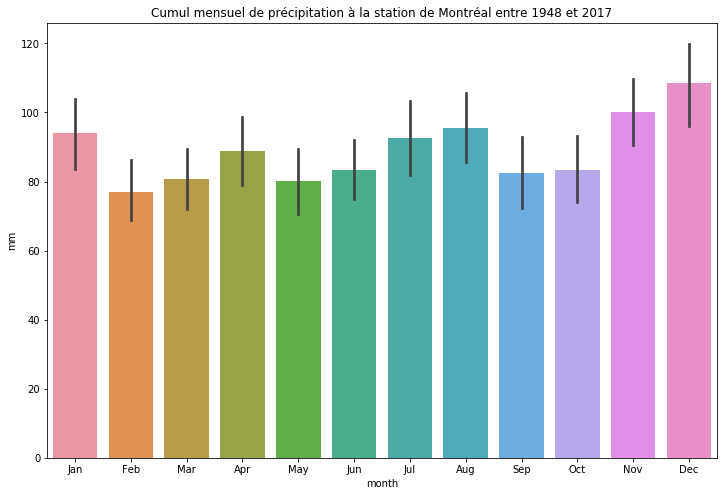

In [16]:
ax = plt.axes()
sns.barplot(x="month", y="sum", data=indice_precipitation)
ax.set_title('Cumul mensuel de précipitation à la station de Montréal entre 1948 et 2017')
ax.set_ylabel('mm')

figure = ax.get_figure()    
figure.set_size_inches(12, 8) 
plt.show()

- Graphiques bi-variés: <b>jointplot()</b>
https://seaborn.pydata.org/generated/seaborn.jointplot.html

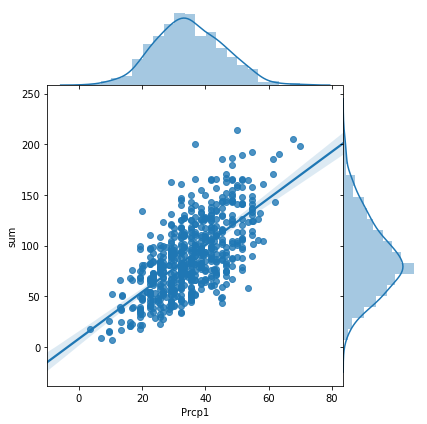

In [17]:
sns.jointplot(x="Prcp1", y="sum", data=indice_precipitation,kind='reg',
                   space=0, height=6, ratio=4)
plt.show()

# kind = 'kde' 
# kind="hex"
# kind="reg"

- Graphiques bi-variés: <b>pairplot()</b>
https://seaborn.pydata.org/generated/seaborn.pairplot.html


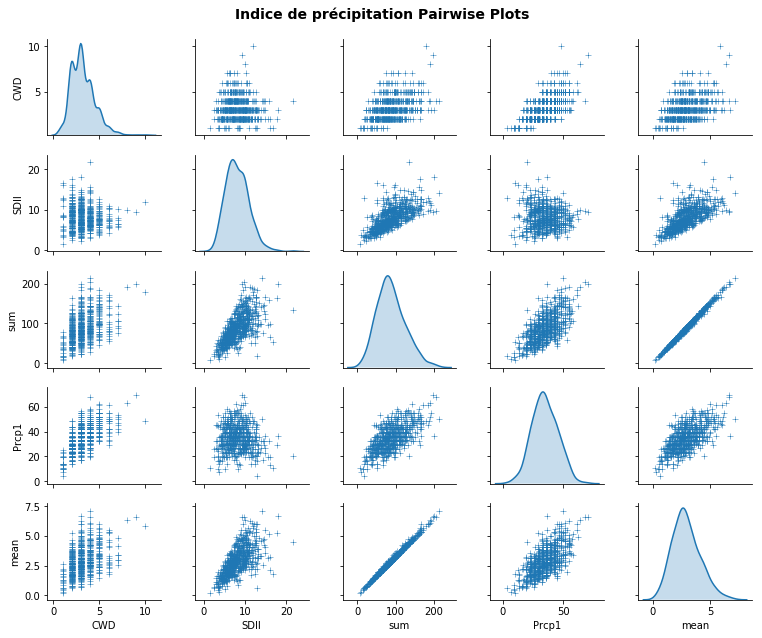

In [18]:
# Attributes of interest
cols = ['CWD', 
        'SDII', 
        'sum', 
        'Prcp1', 
        'mean']

pp = sns.pairplot(indice_precipitation[cols], 
                  height=1.8, aspect=1.2, markers="+",
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kws=dict(shade=True), # "diag" adjusts/tunes the diagonal plots
                  diag_kind="kde") # use "kde" for diagonal plots

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
fig.suptitle('Indice de précipitation Pairwise Plots', 
              fontsize=14, fontweight='bold')
plt.show()




- Matrice de corrélation:
La librairie Pandas possède une méthode permettant de calculer les corrélations entre chaque colonne d'un DataFrame. 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html



In [19]:
indice_precipitation2 = indice_precipitation.drop(["year"], axis=1)
corr_matrix = indice_precipitation2.corr()
corr_matrix

,CDD,CWD,Prcp1,SDII,sum,mean,
CDD,1.000000,-0.288579,-0.687758,0.025358,-0.480416,-0.481019,0.025172
CWD,-0.288579,1.000000,0.631665,-0.040071,0.418940,0.417954,-0.039654
Prcp1,-0.687758,0.631665,1.000000,-0.064514,0.661685,0.663935,-0.064554
SDII,0.025358,-0.040071,-0.064514,1.000000,0.659944,0.661113,0.999642
sum,-0.480416,0.418940,0.661685,0.659944,1.000000,0.997694,0.660287
mean,-0.481019,0.417954,0.663935,0.661113,0.997694,1.000000,0.661422
,0.025172,-0.039654,-0.064554,0.999642,0.660287,0.661422,1.000000


On peut appeller la fonction <b>.heatmap()</b> pour visualiser notre matrice  de corrélation et ainsi faciliter nos interprétations.

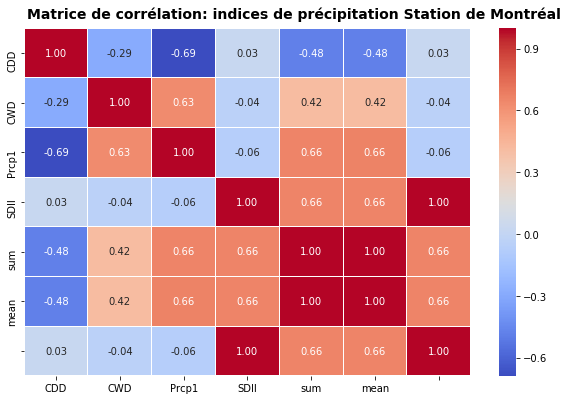

In [20]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,6))
hm = sns.heatmap(corr_matrix, 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 fmt='.2f',       # String formatting code to use when adding annotations.
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)
fig.suptitle('Matrice de corrélation: indices de précipitation Station de Montréal', 
              fontsize=14, 
              fontweight='bold')
plt.show()

- Graphiques 3D: 

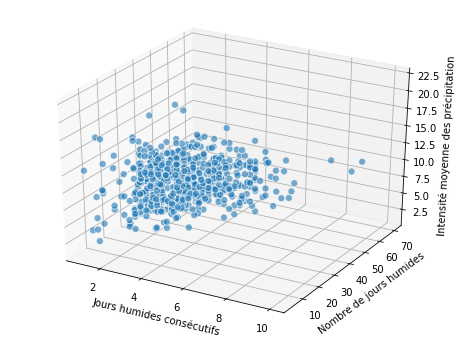

In [21]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

xs = indice_precipitation['CWD']
ys = indice_precipitation['Prcp1']
zs = indice_precipitation['SDII']
ax.scatter(xs, ys, zs, s=50, alpha=0.6, edgecolors='w')

ax.set_xlabel('Jours humides consécutifs')
ax.set_ylabel('Nombre de jours humides')
ax.set_zlabel('Intensité moyenne des précipitation')

plt.show()

### Bonus: ajout des indices de corrélations avec la librairie scipy


Le module <b>stats</b> de la librairie <b>Scipy</b> possède de nombreuses fonctions statistiques. 
https://docs.scipy.org/doc/scipy/reference/stats.html

In [22]:
def corr_pearson(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
   # r, _ = stats.spearmanr(x, y)
    ax = plt.gca()   
    pos = (0, .9) 
    color2='red'                                                                   
    ax.annotate("Pearson = {:.2f}".format(r) + p_stars,
                xy=pos, xycoords=ax.transAxes, color=color2, fontweight='bold')
    

def corr_spearman(x, y, **kws):
    r, p = stats.spearmanr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
   # r, _ = stats.spearmanr(x, y)
    ax = plt.gca()  
    pos = (0, .6) 
    color2='darkgreen' 
    ax.annotate("Spearman = {:.2f}".format(r) + p_stars,
                xy=pos, xycoords=ax.transAxes, color=color2, fontweight='bold')

def corr_kendall(x, y, **kws):
    r, p = stats.kendalltau(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
   # r, _ = stats.spearmanr(x, y)
    ax = plt.gca()   
    pos = (0, .3) 
    color2='darkorange' 
    ax.annotate("Kendall = {:.2f}".format(r) + p_stars,
                xy=pos, xycoords=ax.transAxes, color=color2, fontweight='bold')

In [23]:
indice_precipitation.head()

,CDD,CWD,Prcp1,SDII,sum,mean,,year,month
datetime,,,,,,,,,
1961-01-31,14.0,3.0,29.032258,5.691111,55.09,1.777097,5.691111,1961,Jan
1961-02-28,12.0,3.0,28.571429,9.895000,80.87,2.888214,9.895000,1961,Feb
1961-03-31,16.0,3.0,25.806452,11.868750,97.59,3.148065,11.868750,1961,Mar
1961-04-30,4.0,3.0,50.000000,6.683333,102.70,3.423333,6.683333,1961,Apr
1961-05-31,5.0,3.0,41.935484,5.130000,70.22,2.265161,5.130000,1961,May


In [24]:
indice_month=indice_precipitation[["CWD", "SDII", "sum", "Prcp1"]].loc[(indice_precipitation["month"]=="Jan")]

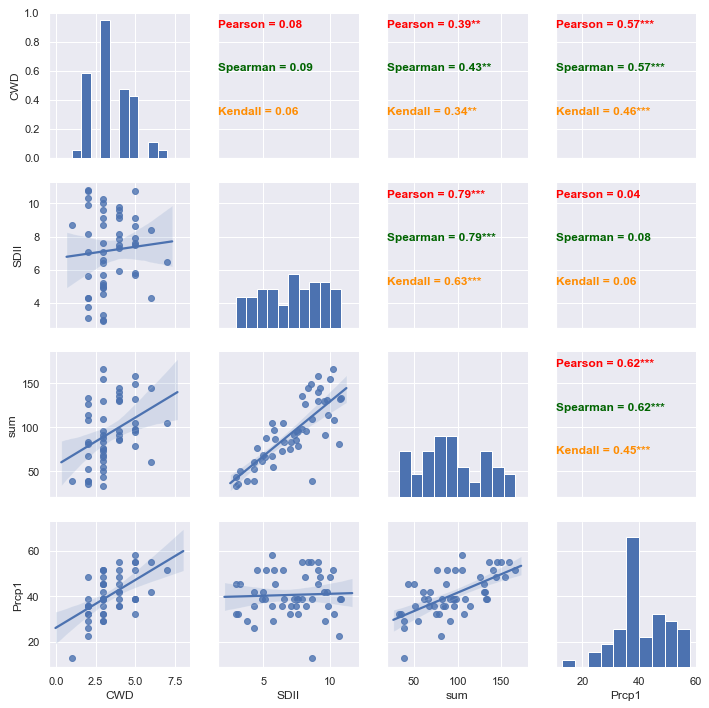

In [25]:
from scipy import stats
import seaborn as sns; sns.set()

g = sns.PairGrid(indice_month[["CWD", "SDII", "sum", "Prcp1"]]) 

g.map_upper(corr_pearson) 
g.map_upper(corr_spearman) 
g.map_upper(corr_kendall) 
g.map_lower(sns.regplot) 
g.map_diag(plt.hist) 
g.set(alpha=0.5)
plt.show()